In [11]:
from scipy.spatial import distance
from scipy.ndimage import gaussian_filter
import os
import cv2
import math
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import numpy as np
from skimage import io, color

In [12]:
def load_image(pathofImage, isGray=True):
    image = io.imread(pathofImage)
    gray = lab = rgb = None
    
    if(len(image.shape)==2):
        gray = image
    elif len(image.shape)>=3:
        lab = color.rgb2lab(image)
        rgb = (color.lab2rgb(lab)*255).astype(np.uint8)
        gray = (color.rgb2gray(image)*255).astype(int)
    else:
        print('_____Image shape not allowed_____')
    
    if isGray:
        return gray
    else:
        return image, lab

In [13]:
#Matrix values with respect to intensity values of the neighbouring pixels
def similatiry_matrix(center_value, window_values, sigma_r, gray_img):
    matrix = np.full(window_values.shape, center_value)
    
    if gray_img:
        d_matrix = np.absolute(window_values-matrix)
    else:
        d_matrix = np.linalg.norm(window_values-matrix, axis=2)
    
    return np.exp((-0.5)*((d_matrix**2/sigma_r**2)))

In [14]:
#Matrix values with respect to closeness of the neighbouring pixels in spatial domain
def spatial_kernel(size, sigma):
    kernel = np.empty((size,size))
    c_x = int(size/2)
    c_y = int(size/2)

    for i in range(size):
        for j in range(size):
            d = distance.euclidean([j, i], [c_x, c_y])
            kernel[j, i] = np.exp((-0.5)*((d**2/sigma**2)))
            
    return kernel

In [15]:
#Filtering the image using similarity matrix and spatial kernal
def bilateral_filter(img, sigma_d, sigma_r, window_size=7):
    height = img.shape[1]
    length = img.shape[0]
    half_wsize = int(window_size/2)
    
    is_gray=None
    if (len(img.shape)==3):
        is_gray=False
    elif (len(img.shape)==2):
        is_gray=True
    
    C_matrix = spatial_kernel(window_size, sigma_d)
    filtered_img = np.zeros(img.shape)
    
    for y in range(height):
        y_low  = max(y-half_wsize, 0)
        y_high = min(y+half_wsize+1, height)
        for x in range(length):
            x_low  = max(x-half_wsize, 0)
            x_high = min(x+half_wsize+1, length)
            
            S_matrix = similatiry_matrix(img[x, y], img[x_low:x_high, y_low:y_high], sigma_r, is_gray)
            w_matrix = C_matrix[half_wsize-x+x_low:x_high-x+half_wsize, half_wsize-y+y_low:y_high-y+half_wsize] * \
                        S_matrix
            
            if not is_gray:
                filtered_pixel = (np.sum(img[x_low:x_high, y_low:y_high]*np.stack((w_matrix,w_matrix,w_matrix), axis=2), axis=(0,1)) / np.sum(w_matrix))
            else:
                filtered_pixel = (np.sum(img[x_low:x_high, y_low:y_high]*w_matrix) / np.sum(w_matrix)).astype(int)
            filtered_img[x, y] = filtered_pixel
            
    return filtered_img

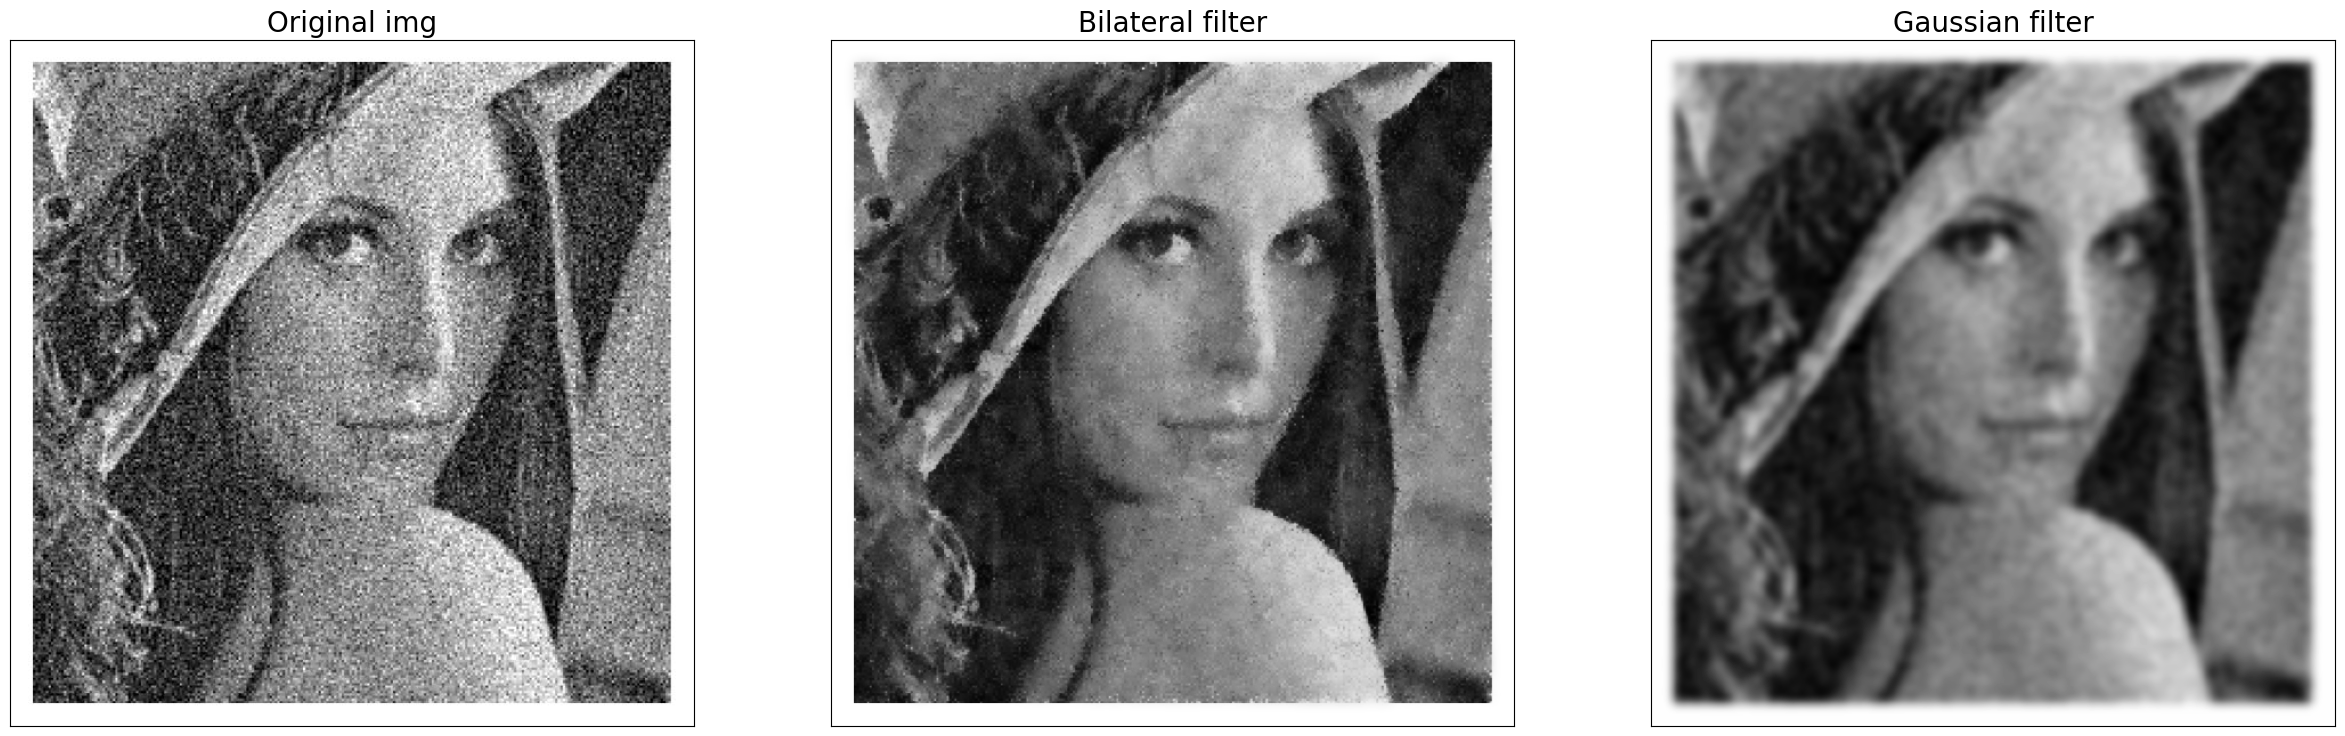

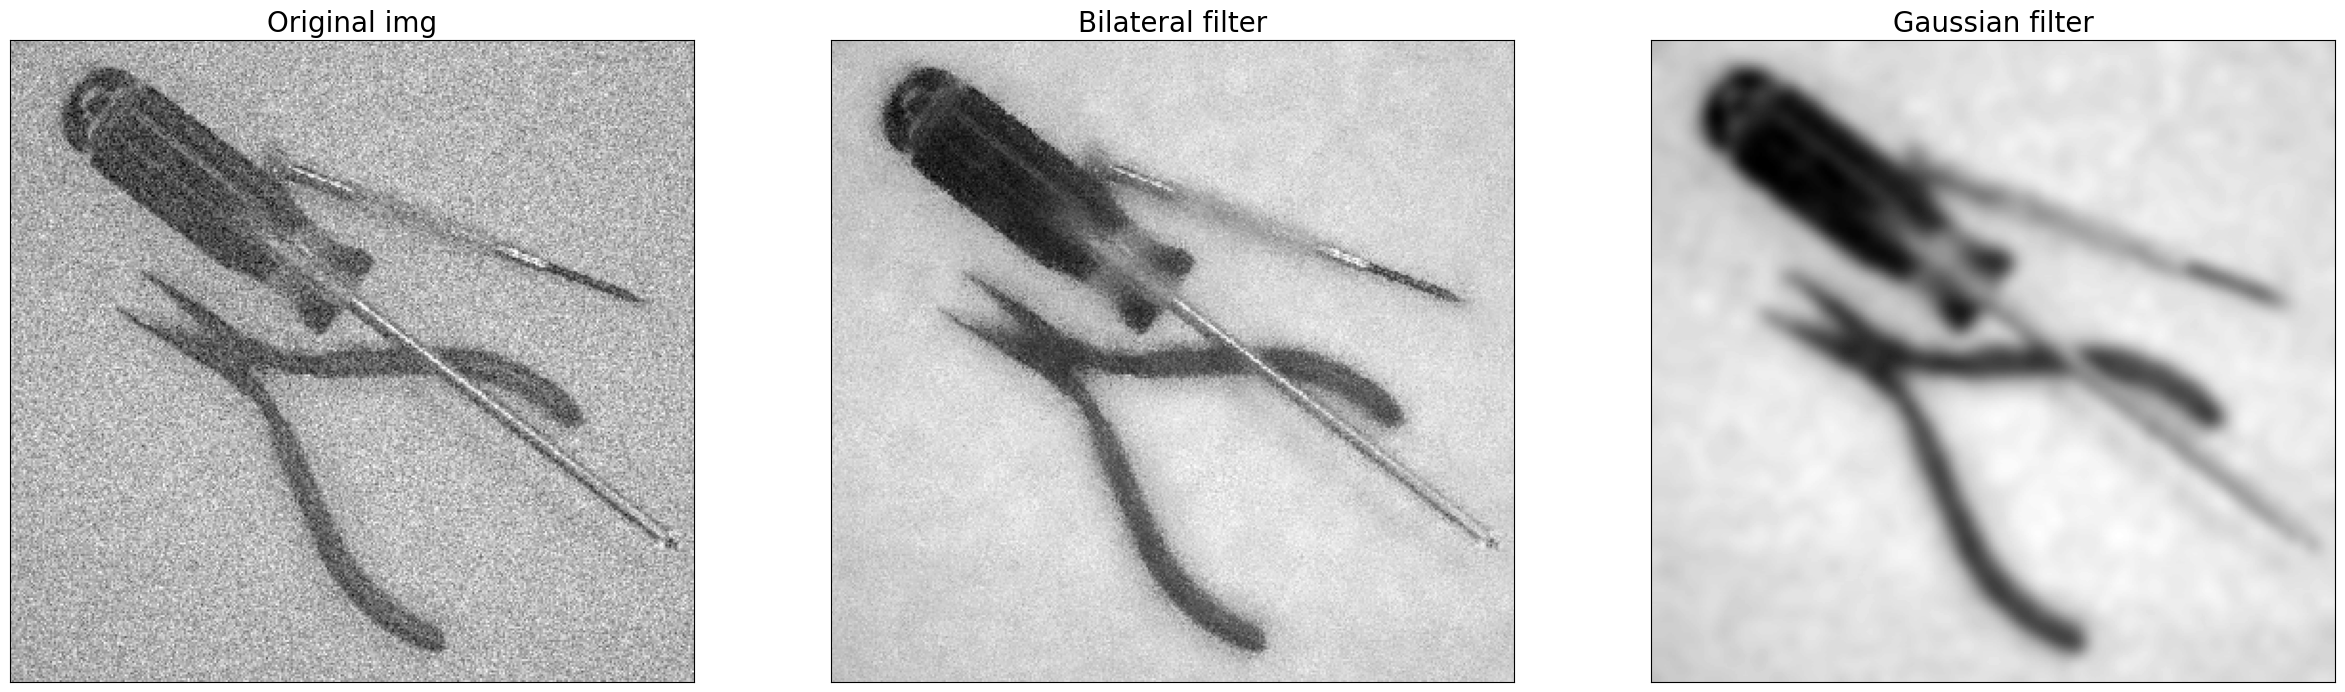

In [16]:
#Comparison of bilateral and gaussian filtering
image_path1 = r'./downloads/lena_noise.jpg'

image_path2 = r'./downloads/tools_noisy.png'

gray_img1 = load_image(image_path1).astype(int)
gray_img2 = load_image(image_path2).astype(int)

f_img = bilateral_filter(gray_img1, sigma_d=5, sigma_r=50, window_size=43)
f_img2 = bilateral_filter(gray_img2, sigma_d=5, sigma_r=50, window_size=43)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,60))
ax1.set_title("Original img", fontsize=20)
ax1.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax1.imshow(gray_img1, cmap='gray')

ax2.set_title("Bilateral filter", fontsize=20)
ax2.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax2.imshow(f_img, cmap='gray')

ax3.set_title("Gaussian filter", fontsize=20)
ax3.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax3.imshow(gaussian_filter(gray_img1, 4), cmap='gray')
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,60))
ax1.set_title("Original img", fontsize=20)
ax1.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax1.imshow(gray_img2, cmap='gray')

ax2.set_title("Bilateral filter", fontsize=20)
ax2.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax2.imshow(f_img2, cmap='gray')

ax3.set_title("Gaussian filter", fontsize=20)
ax3.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax3.imshow(gaussian_filter(gray_img2, 4), cmap='gray')
plt.show()



In [17]:
#Applying different sigma values
save_dir = r"./images/cameraman"
image_path = r'./images/cameraman.jpeg'
gray_img = load_image(image_path).astype(int)

window_size = 43
sigma_d_list = [5,20,80]
sigma_r_list = [10,50,100,300]

padding = 0
img_collage = np.zeros((gray_img.shape[0]*len(sigma_r_list) + padding*(len(sigma_r_list)+1),
                       gray_img.shape[1]*len(sigma_d_list) + padding*(len(sigma_d_list)+1)))

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for i, sigma_d in enumerate(sigma_d_list):
    print("\n[{}/{}]:{}".format(i+1, len(sigma_d_list),sigma_d), end="\n\t")
    for j, sigma_r in enumerate(sigma_r_list):
        print("[{}/{}]:{}".format(j+1, len(sigma_r_list),sigma_r), end='  |  ')

        f_img = bilateral_filter(gray_img, sigma_d, sigma_r, window_size)
        
        #Save the filtered image
        cv2.imwrite(os.path.join(save_dir, 'img_'+str(sigma_d)+'_'+str(sigma_r)+'.jpg'), f_img)    
        img_collage[j*gray_img.shape[0]+j*padding:(j+1)*gray_img.shape[0]+j*padding,
                    i*gray_img.shape[1]+i*padding:(i+1)*gray_img.shape[1]+i*padding] = f_img

cv2.imwrite(os.path.join(save_dir, 'collage.jpg'), img_collage)


[1/3]:5
	[1/4]:10  |  [2/4]:50  |  [3/4]:100  |  [4/4]:300  |  
[2/3]:20
	[1/4]:10  |  [2/4]:50  |  [3/4]:100  |  [4/4]:300  |  
[3/3]:80
	[1/4]:10  |  [2/4]:50  |  [3/4]:100  |  [4/4]:300  |  

True

(-0.5, 511.5, 511.5, -0.5)

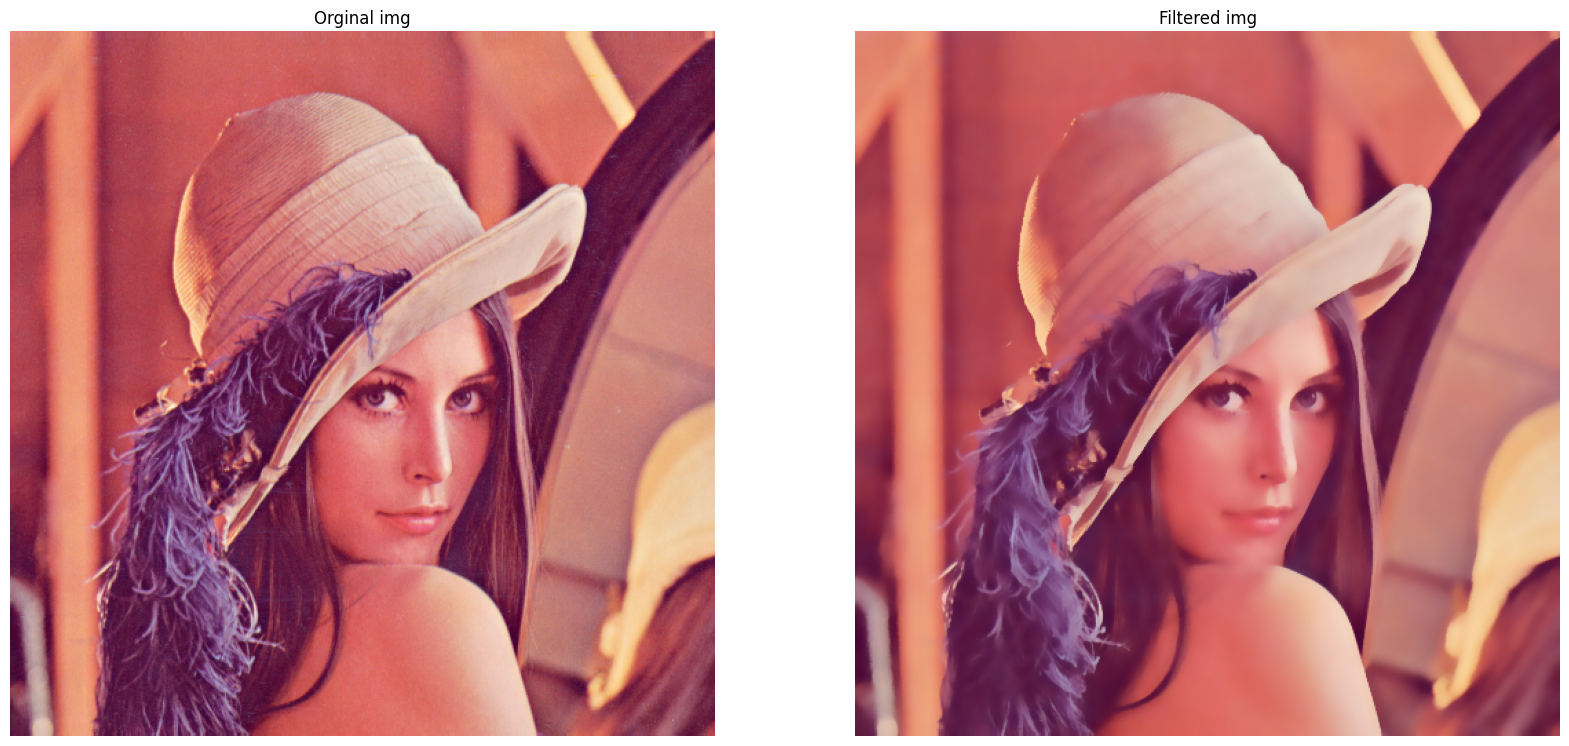

In [18]:
#Bilateral filtering on a color image
image1_path = r'./images/lena512color.tiff'
rgb, lab = load_image(image1_path, False)

filteredimagelab = bilateral_filter(lab, sigma_d=5, sigma_r=15, window_size=9)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,12))
ax1.set_title("Orginal img")
ax1.imshow(rgb)
ax1.axis('off')
ax2.set_title("Filtered img")
ax2.imshow((color.lab2rgb(filteredimagelab)*255).astype(np.uint8))
ax2.axis('off')

In [19]:
#Function that applies bilateral filter on a given image for specified number of iteration. 
def itarate_bilateralFilter(path, image_name, iteration_n=5, w_size=15, s_d=3, s_r=5):
    save_dir = os.path.join(path, image_name[:-4]+"_it")
    image_path = os.path.join(path, image_name)

    rgb_img, lab_img = load_image(image_path, False)
    f_images = []
    f_img_lab = lab_img

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    
    print("Iteration: ",end="")
    for i in range(iteration_n):
        print(i, end=', ')
        f_img_lab = bilateral_filter(f_img_lab, sigma_d=s_d, sigma_r=s_r, window_size=w_size)
        f_images.append(f_img_lab)
        
        f_img_rgb = (color.lab2rgb(f_img_lab)*255).astype(np.uint8)
        cv2.imwrite(os.path.join(save_dir, 'paine_{:03d}.jpg'.format(i)), cv2.cvtColor(f_img_rgb, cv2.COLOR_BGR2RGB))
    
    return f_images

Iteration: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

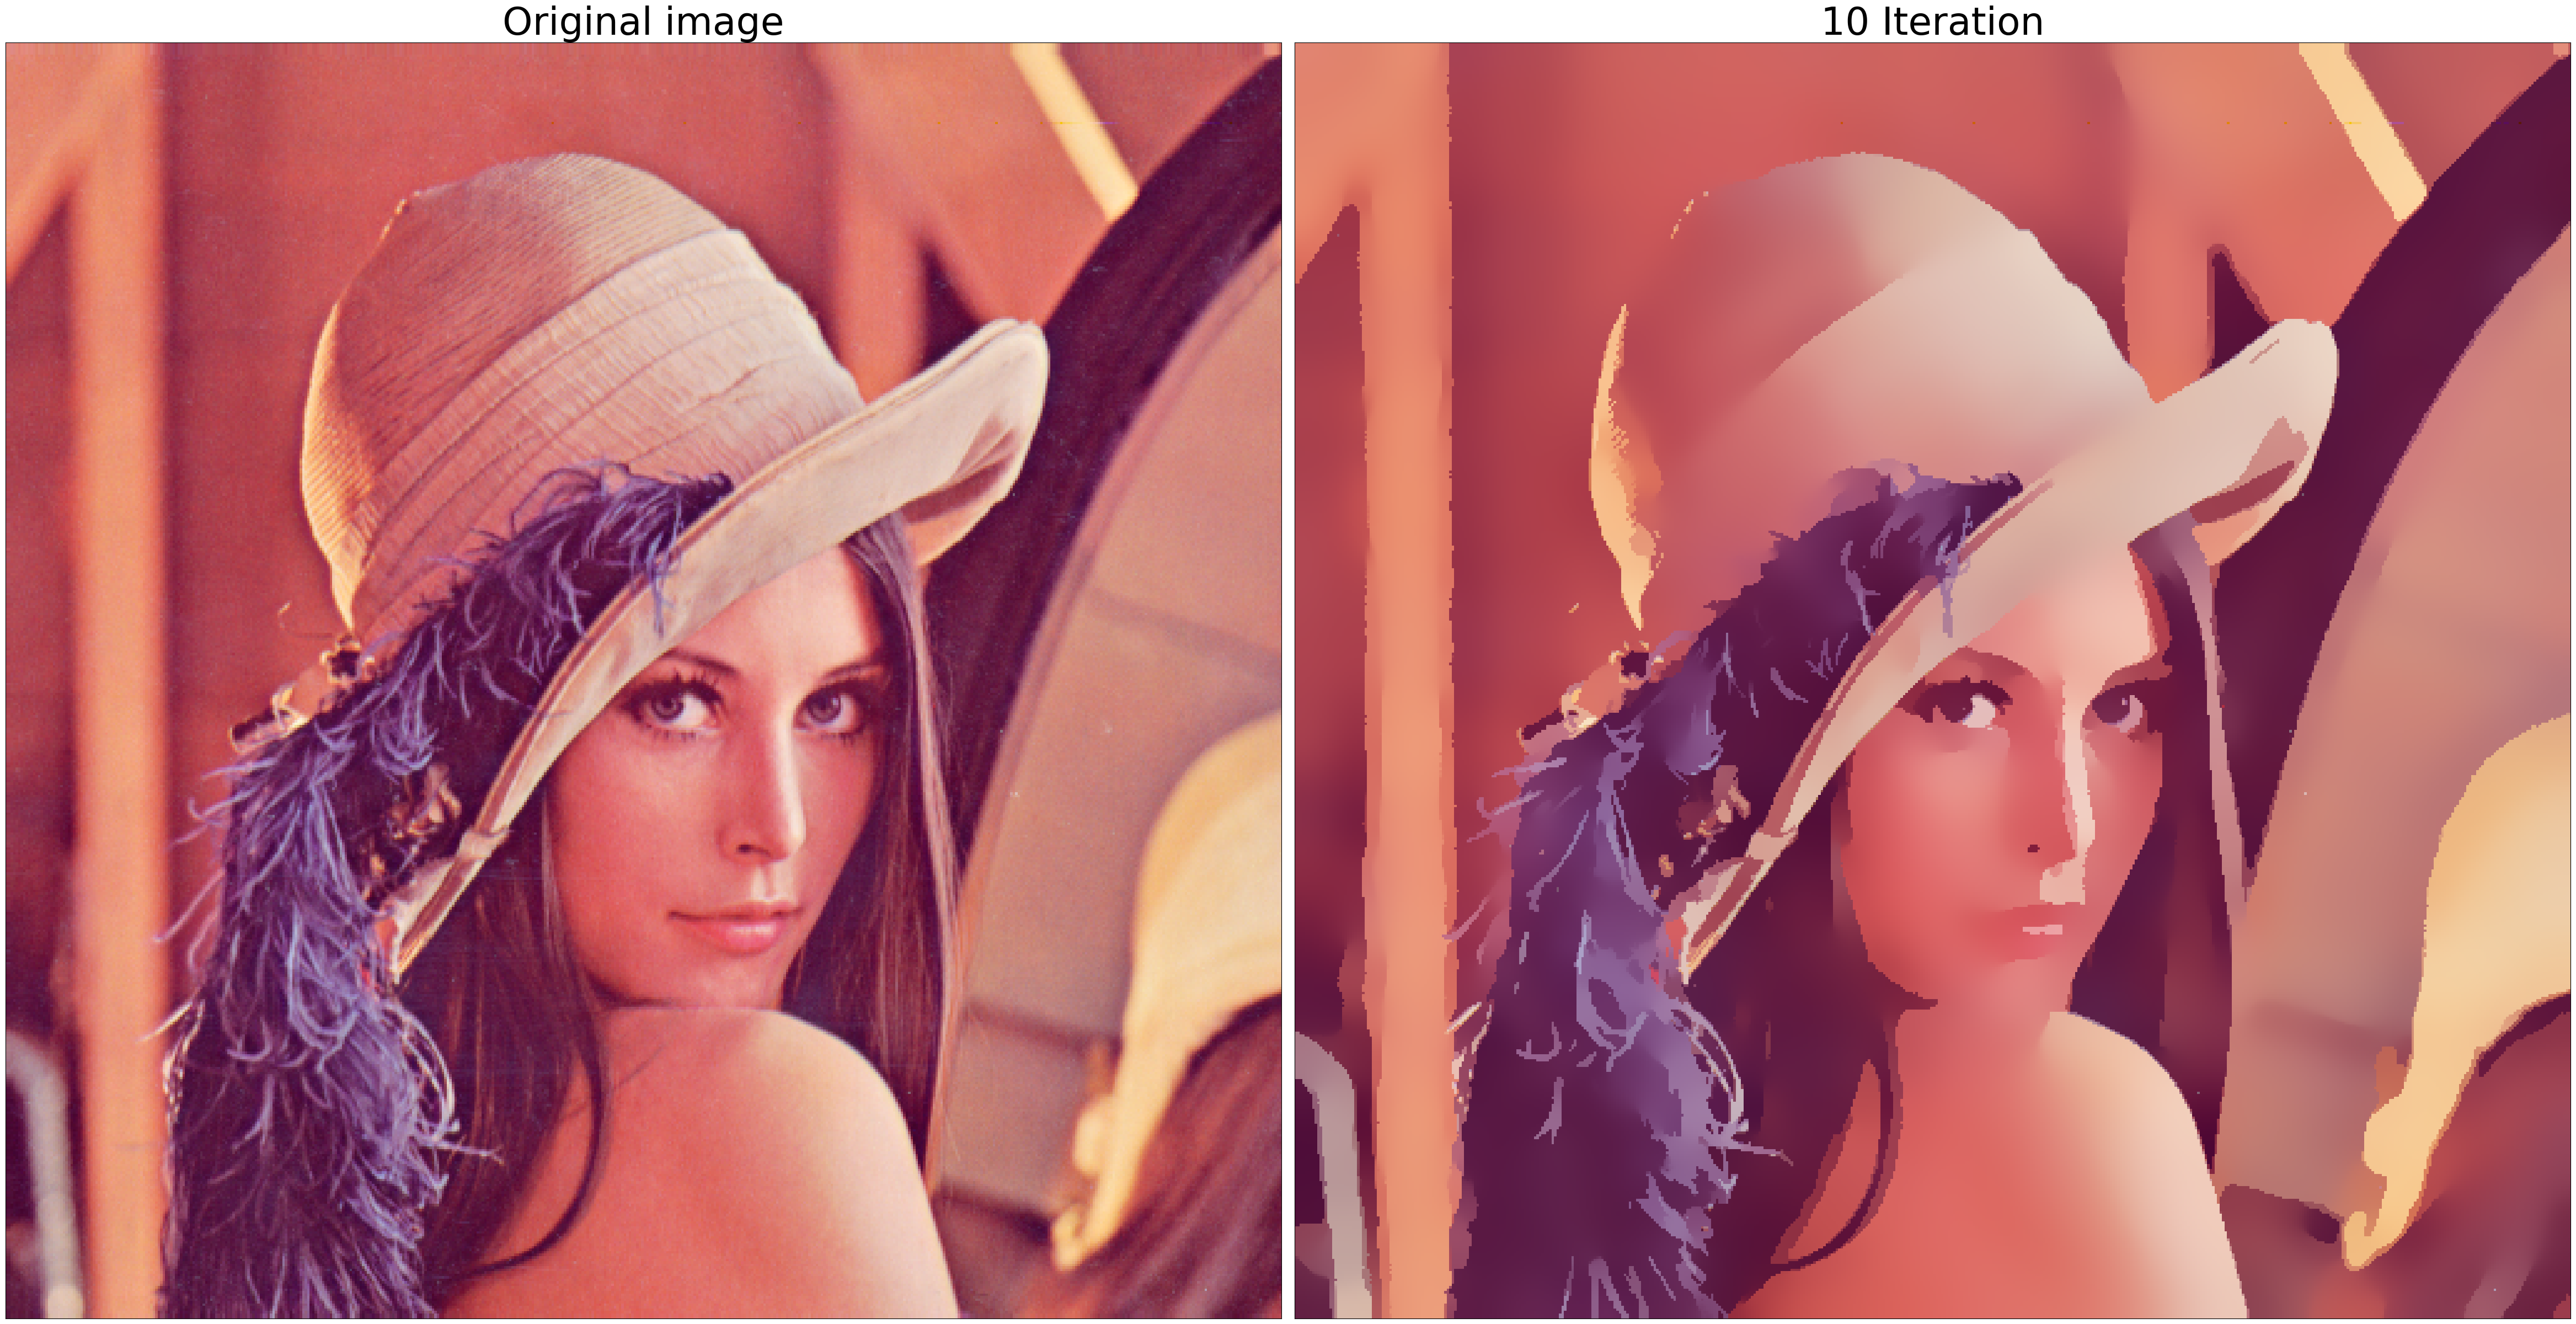

In [20]:
#Applying bilateral filtering for 10 iterations on the same image
image_name = 'lena512color.tiff'
dirname = r"./images"
iteration_number = 10

filterlist = itarate_bilateralFilter(dirname, image_name, iteration_number)
imagepath = r"./images/lena512color.tiff"

rgb, lab = load_image(imagepath, False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(60,60))
ax1.set_title("Original image", fontsize=50)
ax1.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax1.imshow(rgb)

it_n = 9
ax2.set_title(str(it_n+1)+" Iteration", fontsize=50)
ax2.tick_params(axis="both",which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
ax2.imshow((color.lab2rgb(filterlist[it_n])*255).astype(np.uint8))

plt.subplots_adjust(wspace=0.01, hspace=0)